# Распознавание и классификация лиц на изображениях

1. Для поиска лица на изображении воспользуемся моделью **mmod human face detector** (2016 год). Предобученную модель можно скачать по ссылке: https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2.

2. Для выделения характеристических точек лица будем использовать преобученную модель **shape predictor 68 face landmarks** https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2

3. Для извлечения признаков лиц (128D вектор) воспользуемся урезанной моделью основанной на **ResNet-34** (2015 год). Предобученную модель можно скачать по ссылке: dlib_face_recognition_resnet_model_v1.dat.bz2.

4. Небольшой набор с лицами можно скачать по ссылке: https://github.com/lyftzeigen/FaseDetectionAndRecognitionLesson/raw/main/small_faces_dataset.tar.bz2



### Скачаем необходимые модели и распакуем их в директорию **models**

In [2]:
!rm -r models

!wget -P models https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2
!bzip2 -d models/mmod_human_face_detector.dat.bz2

!wget -P models https://github.com/davisking/dlib-models/raw/master/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -d models/shape_predictor_68_face_landmarks.dat.bz2

!wget -P models https://github.com/davisking/dlib-models/raw/master/dlib_face_recognition_resnet_model_v1.dat.bz2
!bzip2 -d models/dlib_face_recognition_resnet_model_v1.dat.bz2

rm: cannot remove 'models': No such file or directory
--2020-10-24 23:36:36--  https://github.com/davisking/dlib-models/raw/master/mmod_human_face_detector.dat.bz2
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2 [following]
--2020-10-24 23:36:36--  https://raw.githubusercontent.com/davisking/dlib-models/master/mmod_human_face_detector.dat.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694687 (678K) [application/octet-stream]
Saving to: ‘models/mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.41K  -

### Скачаем небольшой набор данных с лицами

In [3]:
!rm -r dataset

!wget -P dataset https://github.com/lyftzeigen/FaseDetectionAndRecognitionLesson/raw/main/small_faces_dataset.tar.bz2

!tar -xvf dataset/small_faces_dataset.tar.bz2

!rm dataset/small_faces_dataset.tar.bz2

rm: cannot remove 'dataset': No such file or directory
--2020-10-24 23:36:46--  https://github.com/lyftzeigen/FaseDetectionAndRecognitionLesson/raw/main/small_faces_dataset.tar.bz2
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lyftzeigen/FaseDetectionAndRecognitionLesson/main/small_faces_dataset.tar.bz2 [following]
--2020-10-24 23:36:46--  https://raw.githubusercontent.com/lyftzeigen/FaseDetectionAndRecognitionLesson/main/small_faces_dataset.tar.bz2
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10449990 (10.0M) [application/octet-stream]
Saving to: ‘dataset/small_faces_dataset.tar.bz2’

small_fac

### Импортируем необходимые библиотеки

In [4]:
import os
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from skimage.io import imread, imread_collection
from skimage.color import gray2rgb

%matplotlib inline

### Загрузим скачанные модели

In [5]:
face_detector = dlib.cnn_face_detection_model_v1('models/mmod_human_face_detector.dat')
face_predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
face_recognition = dlib.face_recognition_model_v1('models/dlib_face_recognition_resnet_model_v1.dat')

### Обработаем все фотографии и получим необходимые данные
- Выделим лица на изображениях с помощью **mmod human face detector**
- Предполагается, что на одном фото только одно лицо
- Выделим характеристические точки лиц с помощью модели **shape predictor 68 face landmarks**
- Выделим нормализованный фрагмент лица **chip**
- Получим вектор признаков с помощью модели **face recognition resnet model**

In [6]:
images = imread_collection('dataset/*/*.jpg')

named_images = {}

for (image, path) in zip(images, images.files):
  # Получим имя претендента на распознание
  name = os.path.basename(os.path.dirname(path))

  # Сохраняем в словарь
  if name in named_images:
    named_images[name].append({'image': image, 'path': path})
  else:
    named_images[name] = [{'image': image, 'path': path}]

for name in named_images:
  for data in named_images[name]:
    data['face'] = face_detector(data['image'])[0]
    data['landmarks'] = face_predictor(data['image'], data['face'].rect)
    data['chip'] = dlib.get_face_chip(data['image'], data['landmarks'])
    data['features'] = face_recognition.compute_face_descriptor(data['chip'])

### Посмотрим на результат

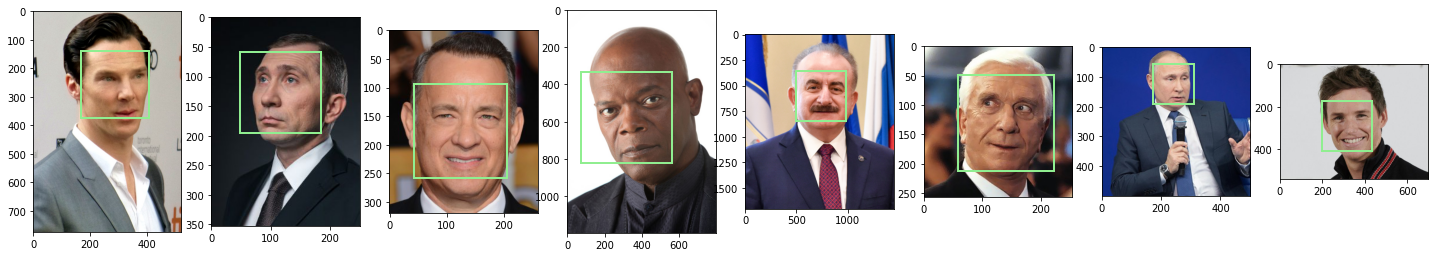

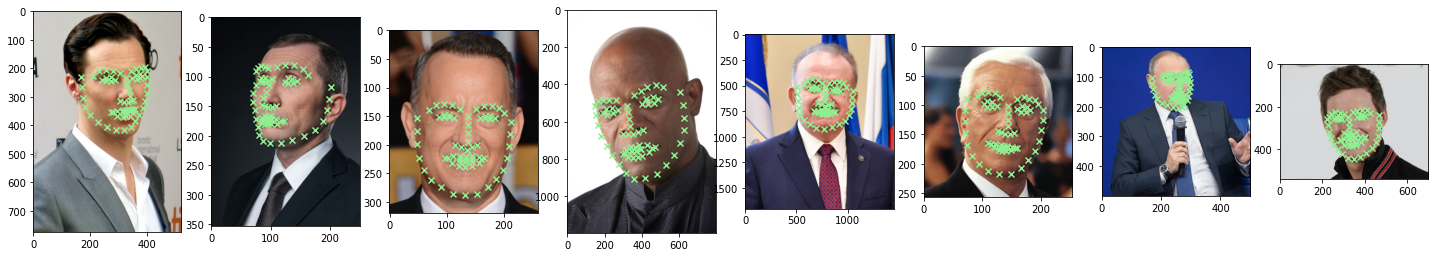

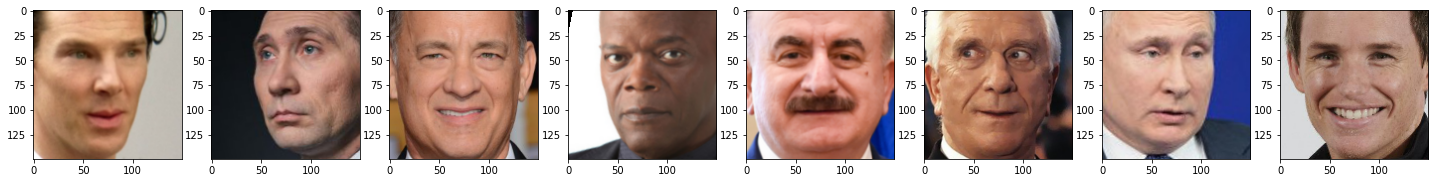

In [7]:
# Нарисуем рамку вокруг лица
fig, ax = plt.subplots(1, len(named_images), figsize=(25, 5))
for i, name in enumerate(named_images):  
  image = named_images[name][0]['image']
  face = named_images[name][0]['face']

  ax[i].imshow(image)
  ax[i].add_patch(patches.Rectangle((face.rect.left(),
                                     face.rect.top()),
                                     face.rect.right() - face.rect.left(),
                                     face.rect.bottom() - face.rect.top(),
                                     edgecolor='lightgreen',
                                     facecolor='none',
                                     linewidth=2))
fig.show()

# Посмотрим на характеристические точки
fig, ax = plt.subplots(1, len(named_images), figsize=(25, 5))
for i, name in enumerate(named_images):
  image = named_images[name][0]['image']
  landmarks = named_images[name][0]['landmarks']   
  ax[i].imshow(image)    
  for part in landmarks.parts():
    ax[i].scatter(part.x, part.y, color='lightgreen', marker='x')
fig.show()

# Выделим фрагмент с лицом
fig, ax = plt.subplots(1, len(named_images), figsize=(25, 5))
for i, name in enumerate(named_images):
  chip = named_images[name][0]['chip']

  ax[i].imshow(chip)
fig.show()

### Проведем кластерный анализ методом TSNE
- Обратим внимание, что похожие изобрежения **putin** и **grachev** находятся близко друг к другу, а **jeckson** дальше всех

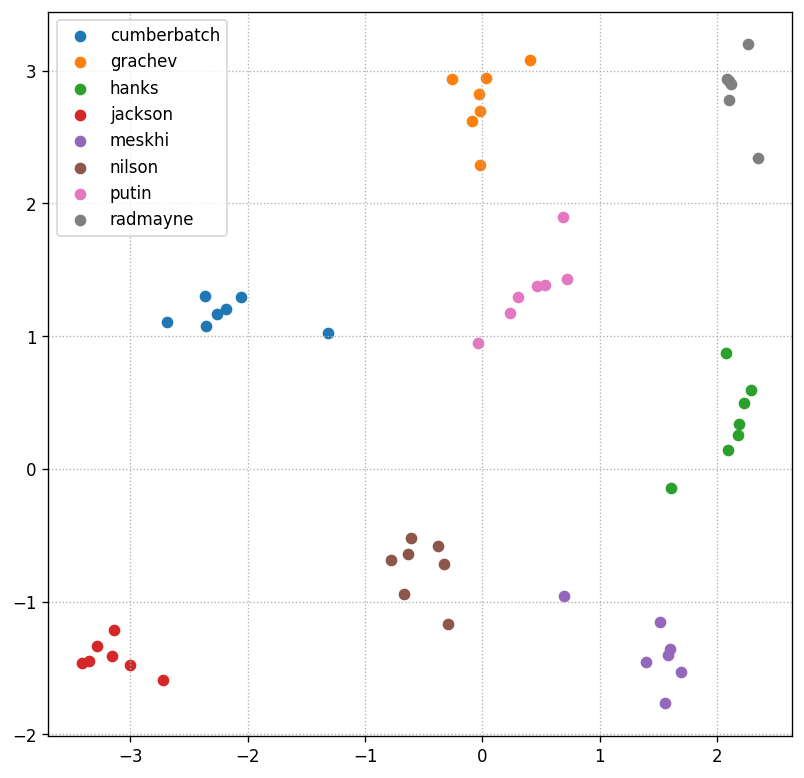

In [15]:
all_names = [name
             for name in named_images
             for data in named_images[name]]

all_features = [data['features']
                for name in named_images
                for data in named_images[name]]

# Сокращаем размерность векторов до 2D
tsne = TSNE(learning_rate=2, init='random', random_state=2020)
all_features = tsne.fit_transform(all_features)

# Добавляем координаты в словарь
grouped = {}

for name, point in zip(all_names, all_features):
  if name not in grouped:
    grouped[name] = [point]   
  else:
    grouped[name].append(point)

fig, ax = plt.subplots(dpi=120, figsize=(8, 8))

for name in grouped:
  points = grouped[name]
  x, y = zip(*points)
  ax.scatter(x, y)

ax.grid(linestyle=':')
ax.legend(grouped.keys(), loc='upper left')

fig.show()

### А теперь попробуем найти лицо на групповой фотографии из загруженного датасета
- Для этого построим вектора признаков для каждого лица на групповом фото
- Найдем евклидовы расстояния между лицами из датасета и лацами на групповом фото
- Выделим самые близкие лица по пороговому значению 0.6 - 0.65

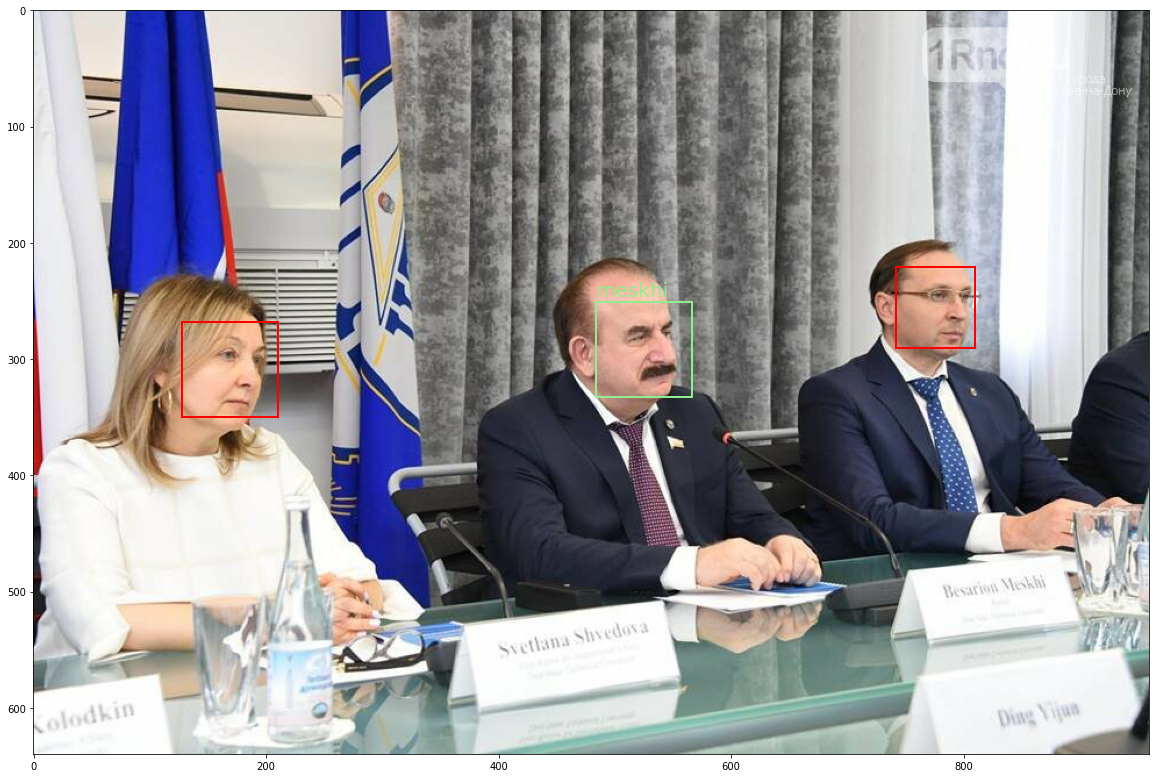

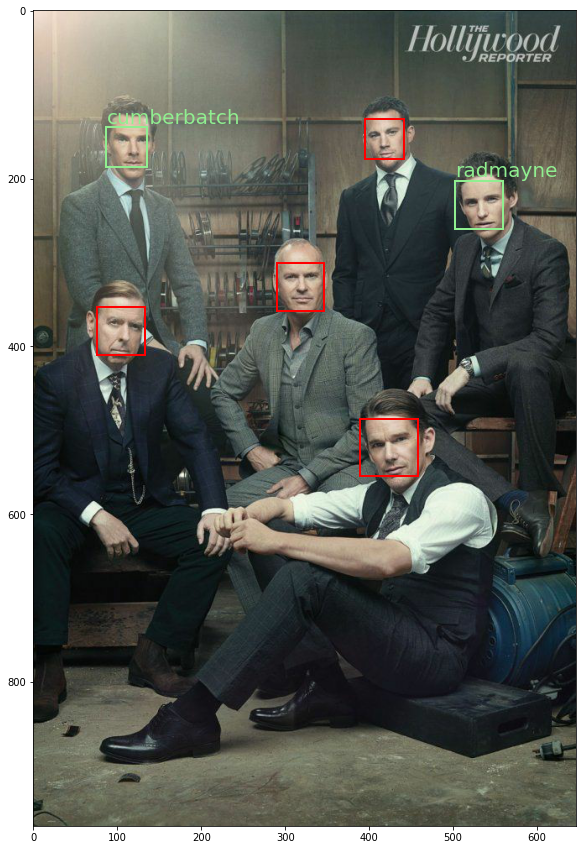

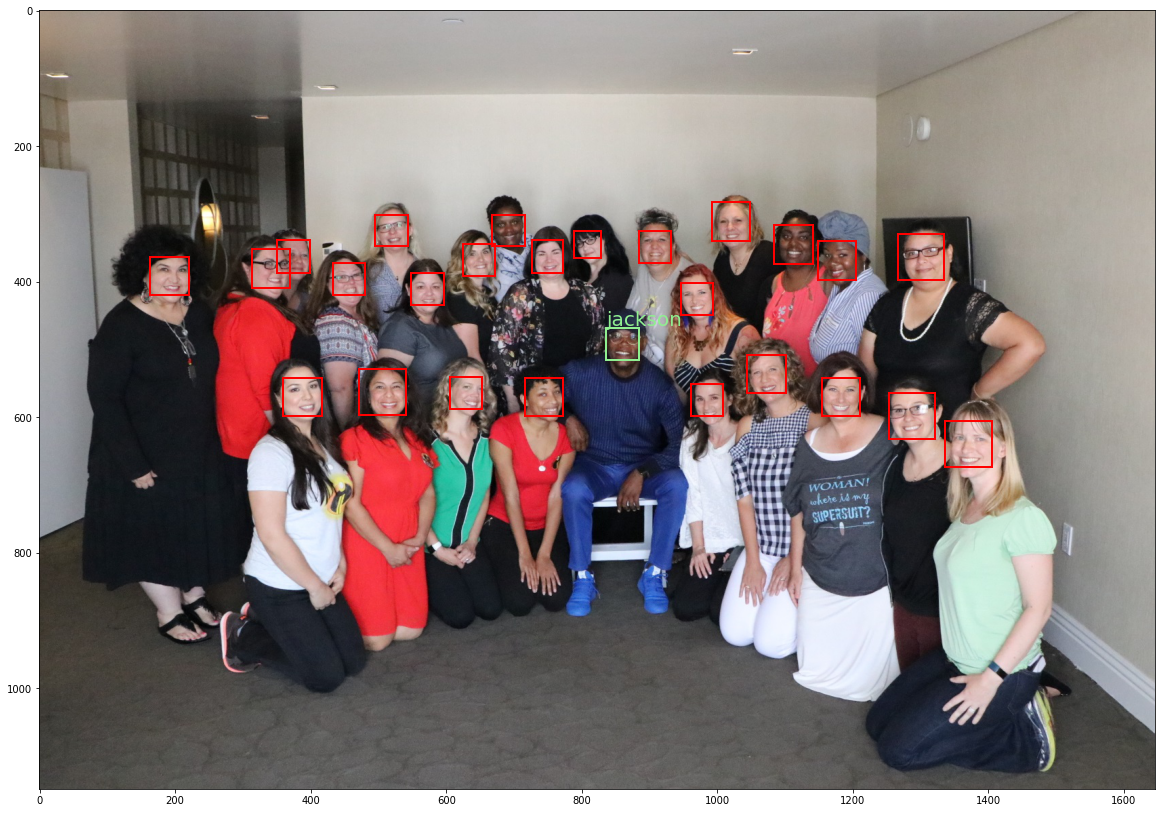

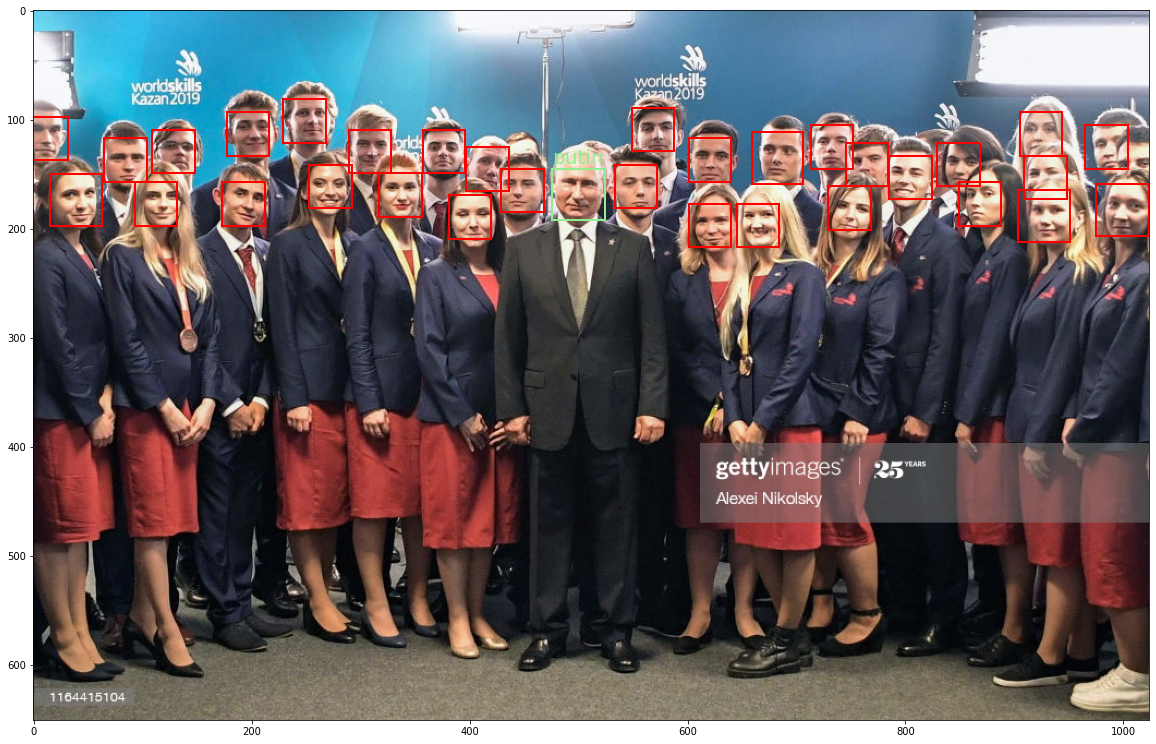

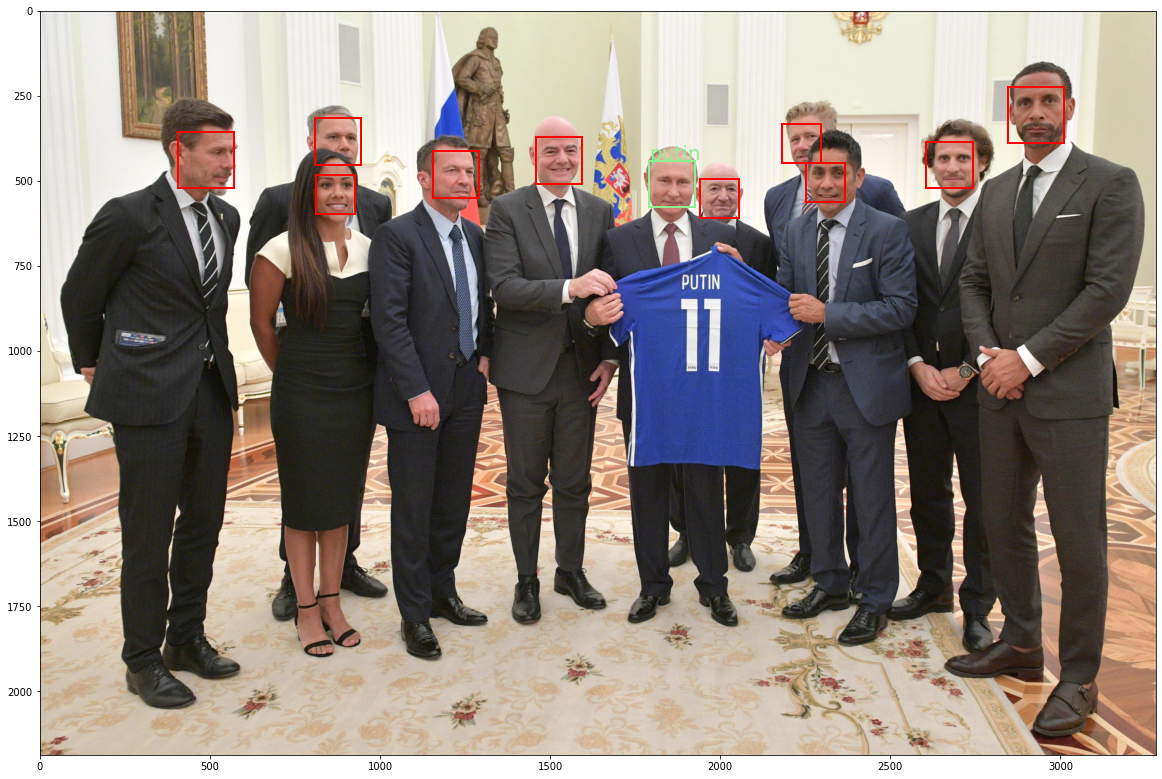

In [14]:
group_photos = imread_collection('dataset/group_photo*.jpg')

for photo in group_photos:
  # Расчитаем увеличение фото для более точно поиска лиц
  resolution = photo.shape[0] * photo.shape[1]

  # Устанавливаем коэфицент увеличения
  if resolution < 3E+6:
    factor = 1
  else:
    factor = 0


  # Найдем лица на фото
  photo_faces = face_detector(photo, factor)

  # Обраюотанные лица на груповом фото
  faces = []

  # Для каждого лица найдем признаки
  for face in photo_faces:
    face_landmarks = face_predictor(photo, face.rect)
    face_chip = dlib.get_face_chip(photo, face_landmarks)
    face_features = face_recognition.compute_face_descriptor(face_chip)
    face_features = np.array(face_features)

    named_distances = {}

    # Сравним эти признаки со всеми категориями из датасета
    for name in named_images:
      average_distance = []

      for data in named_images[name]:
        known_features = data['features']
        known_features = np.array(known_features)
        euclidian_dist = np.linalg.norm(face_features - known_features)
        average_distance.append(euclidian_dist)

      average_distance = np.average(average_distance)

      named_distances[name] = average_distance

    # Находим наименьшее среднее расстояние для текущего лица
    shortest_distance = sorted(named_distances.items(),
                               key=lambda item: item[1])[0]
    
    name, shortest_distance = shortest_distance

    faces.append({'rect': face.rect,
                  'name': name,
                  'distance': shortest_distance})

    # Покажем результат
  fig, ax = plt.subplots(figsize=(20, 15))

  # Нарисуем изображение
  ax.imshow(photo)

  # Обозначим распознанные и нераспознанные лица
  for f in faces:
    name = f['name']
    rect = f['rect']
    distance = f['distance']
      
    if distance <= 0.55:
      ax.text(rect.left(), rect.top() - 5, name, fontsize=20, color='lightgreen')
      ax.add_patch(patches.Rectangle((rect.left(),
                                      rect.top()),
                                      rect.right() - rect.left(),
                                      rect.bottom() - rect.top(),
                                      edgecolor='lightgreen',
                                      facecolor='none',
                                      linewidth=2))
    else:      
      ax.add_patch(patches.Rectangle((rect.left(),
                                      rect.top()),
                                      rect.right() - rect.left(),
                                      rect.bottom() - rect.top(),
                                      edgecolor='red',
                                      facecolor='none',
                                      linewidth=2)) 

  fig.show()